In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Codes/'

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Codes/'
/content


## **Imports**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import librosa
from PIL import Image
from IPython.display import Audio, display

import numpy as np
from numpy.random import uniform, normal, randint
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.signal as ss

# **Signal**

## **Dataset**

In [4]:
class SignalDataset(Dataset):
  
  def __init__(self, function=[lambda t: np.sin(2 * np.pi * t)], data_size=32, period=1, period_num=10, sample_rate=100, 
               gaussian_noise=True, noise_variance=0.1, wss_noise=True, mean_variation=0.1, var_variation=0.1, visualization=False):
    
    dimension = len(function)
    self.data_size = data_size

    signal_len = round(period_num * period * sample_rate)
    self.time_steps = np.linspace(0, period_num * period, signal_len, endpoint=False)

    vector_function = lambda t: np.stack([f(t) for f in function], axis=-1)
    self.clean_data = vector_function(self.time_steps)

    self.clean_data = np.tile(self.clean_data, (data_size, 1, 1))
    self.noisy_data = np.zeros_like(self.clean_data)
    
    if wss_noise:
      noise_mean = np.zeros((signal_len, 1))
      noise_std = np.full((signal_len, 1), np.sqrt(noise_variance))
    else:
      noise_mean = uniform(0 - mean_variation, 0 + mean_variation, (signal_len, 1))
      noise_std = uniform(np.sqrt(max(noise_variance - var_variation, 0)), 
                          np.sqrt(noise_variance + var_variation), (signal_len, 1))

    time_shifter = lambda: randint(round(period * sample_rate))

    for i in range(data_size):
      self.clean_data[i] = np.roll(self.clean_data[i], time_shifter(), axis=0)
      self.noisy_data[i] = self.clean_data[i]

      if gaussian_noise:
        self.noisy_data[i] += normal(noise_mean, noise_std, (signal_len, dimension))
      else:
        self.noisy_data[i] += uniform(noise_mean - np.sqrt(3) * noise_std, noise_mean + np.sqrt(3) * noise_std, (signal_len, dimension))
        
    if visualization:
      index = randint(data_size)
      clean_data = self.clean_data[index]
      noisy_data = self.noisy_data[index]

      if dimension == 1:
        plt.figure()
        plt.plot(self.time_steps, noisy_data)
        plt.plot(self.time_steps, clean_data)
        plt.xlabel('time (s)')
        plt.ylabel('value')
        plt.legend(['Noisy Data', 'Clean Data'])
        plt.show()

      elif dimension == 2:
        plt.figure()
        plt.axis('equal')
        plt.plot(noisy_data[:, 0], noisy_data[:, 1])
        plt.plot(clean_data[:, 0], clean_data[:, 1])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Noisy Data', 'Clean Data'])
        plt.show()
    
  def __len__(self):
    return self.data_size

  def __getitem__(self, index):
    return self.time_steps.astype(np.float32), self.clean_data[index].astype(np.float32), self.noisy_data[index].astype(np.float32)


## **Model**

In [5]:
class Denoising(nn.Module):
  def __init__(self, dimension=1, hidden_size=30, lstm=False):
    super(Denoising, self).__init__()
    model = nn.LSTM if lstm else nn.RNN

    self.rnn = model(dimension, hidden_size, batch_first=True)
    self.linear = nn.Linear(hidden_size, dimension)

  def forward(self, x):
    rnn_out, _ = self.rnn(x.to(torch.float32))
    pred = self.linear(rnn_out)
    return pred
    

## **Functions**

In [6]:
def trainSignal(model, num_epochs, train_dataloader, valid_dataloader, optimizer, criterion, accuracy, clean_train=True, dict_result=None):

  criterion_ = lambda x, y, z: criterion(y, z) if clean_train else criterion(x, y)

  if dict_result:
    tr_loss = np.concatenate((dict_result['tr_loss'], np.zeros((num_epochs))))
    tr_snr = np.concatenate((dict_result['tr_snr'], np.zeros((num_epochs))))

    val_loss = np.concatenate((dict_result['val_loss'], np.zeros((num_epochs))))
    val_snr = np.concatenate((dict_result['val_snr'], np.zeros((num_epochs))))

    epoch = dict_result['epoch']
    time = dict_result['time']

    pbar = tqdm(range(epoch, epoch + num_epochs), total=num_epochs, position=0, leave=False)
    pbar.start_t -= time
    pbar.display(f'Training: loss={tr_loss[-num_epochs - 1]:.3f} snr={tr_snr[-num_epochs - 1]:+.3f}dB | '
                 f'Validation: loss={val_loss[-num_epochs - 1]:.3f} snr={val_snr[-num_epochs - 1]:+.3f}dB | '
                 f'epoch={epoch + 1}/{epoch + num_epochs}:' + pbar.format_meter(0, num_epochs, time, rate=epoch / time))
    num_epochs += epoch

  else:
    tr_loss = np.zeros((num_epochs))
    tr_snr = np.zeros((num_epochs))
    
    val_loss = np.zeros((num_epochs))
    val_snr = np.zeros((num_epochs))

    pbar = tqdm(range(num_epochs), total=num_epochs, position=0, leave=False)
    dict_result = {}

  for epoch in pbar:
    model.train()
    tr_epoch_loss = 0
    tr_epoch_snr = 0
    count = 0

    for _, clean_data, noisy_data in train_dataloader:
      if torch.cuda.is_available():
        clean_data = clean_data.cuda()
        noisy_data = noisy_data.cuda()

      optimizer.zero_grad()
      denoised_data = model(noisy_data)
      loss = criterion_(noisy_data, denoised_data, clean_data)
      snr = accuracy(denoised_data, clean_data)

      loss.backward()
      optimizer.step()
      tr_epoch_loss += loss.item()
      tr_epoch_snr += snr.item()
      count += 1
    
    tr_epoch_loss /= count
    tr_epoch_snr /= count

    tr_loss[epoch] = tr_epoch_loss
    tr_snr[epoch] = tr_epoch_snr

    model.eval()
    val_epoch_loss = 0
    val_epoch_snr = 0
    count = 0

    for _, clean_data, noisy_data in valid_dataloader:
      if torch.cuda.is_available():
        clean_data = clean_data.cuda()
        noisy_data = noisy_data.cuda()
      
      with torch.no_grad():
        denoised_data = model(noisy_data)
        loss = criterion_(noisy_data, denoised_data, clean_data)
        snr = accuracy(denoised_data, clean_data)

        val_epoch_loss += loss.item()
        val_epoch_snr += snr.item()
        count += 1
    
    val_epoch_loss /= count
    val_epoch_snr /= count

    val_loss[epoch] = val_epoch_loss
    val_snr[epoch] = val_epoch_snr

    pbar.set_description(f'Training: loss={tr_epoch_loss:.3f} snr={tr_epoch_snr:+.3f}dB | Validation: loss={val_epoch_loss:.3f} snr={val_epoch_snr:+.3f}dB | epoch={epoch + 1}/{num_epochs}')

  pbar.display()

  time = pbar.format_dict['elapsed']
  dict_result['time'] = time
  dict_result['epoch'] = num_epochs

  dict_result['tr_loss'] = tr_loss
  dict_result['tr_snr'] = tr_snr

  dict_result['val_loss'] = val_loss
  dict_result['val_snr'] = val_snr

  return dict_result


def evaluationSignal(model, test_dataloader, criterion, accuracy, clean_train, dict_result, num_visual=5):

  criterion_ = lambda x, y, z: criterion(y, z) if clean_train else criterion(x, y)

  model.eval()
  test_loss = 0
  test_snr_in = 0
  test_snr_out = 0
  count = 0

  for time_steps, clean_data, noisy_data in test_dataloader:
    if torch.cuda.is_available():
      clean_data = clean_data.cuda()
      noisy_data = noisy_data.cuda()

    with torch.no_grad():
      denoised_data = model(noisy_data)
      loss = criterion_(noisy_data, denoised_data, clean_data)
      snr_in = accuracy(noisy_data, clean_data)
      snr_out = accuracy(denoised_data, clean_data)

      test_loss += loss.item()
      test_snr_in += snr_in.item()
      test_snr_out += snr_out.item()
      count += 1
  
  test_loss /= count
  test_snr_in /= count
  test_snr_out /= count

  print(f'Testing: loss={test_loss:.3f} snr_in={test_snr_in:+.3f}dB snr_out={test_snr_out:+.3f}dB')
  
  epochs = range(1, dict_result['epoch'] + 1)

  plt.figure()
  plt.plot(epochs, dict_result['tr_loss'])
  plt.plot(epochs, dict_result['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss')
  plt.legend(['Train', 'Valid'])
  plt.show()
  
  plt.figure()
  plt.plot(epochs, dict_result['tr_snr'])
  plt.plot(epochs, dict_result['val_snr'])
  plt.xlabel('epoch')
  plt.ylabel('snr')
  plt.title('SNR')
  plt.legend(['Train', 'Valid'])
  plt.show()

  dimension = clean_data.shape[2]
  for index in range(min(clean_data.shape[0], num_visual)):
    print()
    print(f'Sample {index + 1}:')
    if dimension == 1:
      plt.figure()
      plt.plot(time_steps[index].cpu().numpy().squeeze(), noisy_data[index].cpu().numpy().squeeze(), 'C0')
      plt.plot(time_steps[index].cpu().numpy().squeeze(), clean_data[index].cpu().numpy().squeeze(), 'k')
      plt.plot(time_steps[index].cpu().numpy().squeeze(), denoised_data[index].cpu().numpy().squeeze(), 'C1')
      plt.xlabel('time (s)')
      plt.ylabel('value')
      plt.legend(['Noisy Data', 'Clean Data', 'Denoised Data'])
      plt.show()

    elif dimension == 2:
      plt.figure()
      plt.axis('equal')
      plt.plot(noisy_data[index].cpu().numpy().squeeze()[:, 0], noisy_data[index].cpu().numpy().squeeze()[:, 1], 'C0')
      plt.plot(clean_data[index].cpu().numpy().squeeze()[:, 0], clean_data[index].cpu().numpy().squeeze()[:, 1], 'k')
      plt.plot(denoised_data[index].cpu().numpy().squeeze()[:, 0], denoised_data[index].cpu().numpy().squeeze()[:, 1], 'C1')
      plt.xlabel('x')
      plt.ylabel('y')
      plt.legend(['Noisy Data', 'Clean Data', 'Denoised Data'])
      plt.show()


## **Parameters**

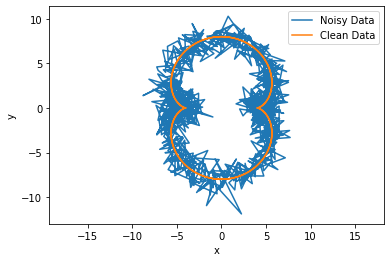

In [61]:
# function = [lambda t: np.sin(2 * np.pi * t)]
# function = [lambda t: ss.sawtooth(2 * np.pi * t)]
# function = [lambda t: ss.sawtooth(2 * np.pi * t, 0.5)]

# function = [lambda t: np.cos(2 * np.pi * t), lambda t: np.sin(2 * np.pi * t)]
# a = 5
# b = 3
# c = 5
# function = [lambda t: (a + b) * np.cos(2 * np.pi * t) - c * np.cos((a / b + 1) * 2 * np.pi * t), lambda t: (a + b) * np.sin(2 * np.pi * t) - c * np.sin((a / b + 1) * 2 * np.pi * t)]
a = 2
function = [lambda t: a * (np.cos(3 * 2 * np.pi * t) - 3 * np.cos(2 * np.pi * t)), lambda t: a * (np.sin(3 * 2 * np.pi * t) - 3 * np.sin(2 * np.pi * t))]

data_size = 1000
period = 1
sample_rate = 50
period_len = round(period * sample_rate)
gaussian_noise = True
noise_variance = 1
wss_noise = True
mean_variation = 1
var_variation = 1

dimension = len(function)
batch_size = 100
hidden_size = 32
lstm = True
learning_rate = 0.01
num_epochs = 50
num_visual = 5

train_dataset = SignalDataset(function=function, data_size=data_size, period=period, period_num=7, sample_rate=sample_rate, 
                              gaussian_noise=gaussian_noise, noise_variance=noise_variance, 
                              wss_noise=wss_noise, mean_variation=mean_variation, var_variation=var_variation, visualization=False)
valid_dataset = SignalDataset(function=function, data_size=data_size, period=period, period_num=1, sample_rate=sample_rate, 
                              gaussian_noise=gaussian_noise, noise_variance=noise_variance, 
                              wss_noise=wss_noise, mean_variation=mean_variation, var_variation=var_variation, visualization=False)
test_dataset = SignalDataset(function=function, data_size=data_size, period=period, period_num=2, sample_rate=sample_rate, 
                              gaussian_noise=gaussian_noise, noise_variance=noise_variance, 
                              wss_noise=wss_noise, mean_variation=mean_variation, var_variation=var_variation, visualization=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=data_size)
test_dataloader = DataLoader(test_dataset, batch_size=data_size)

dict_result = None
model = Denoising(dimension=dimension, hidden_size=hidden_size, lstm=lstm)
if torch.cuda.is_available():
  model = model.cuda()

clean_train = True
criterion = nn.MSELoss() if clean_train else lambda x, y: torch.mean(torch.var(torch.stack(torch.split(torch.cat([x, y], dim=1), period_len, dim=1)[:None if x.shape[1] % period_len == 0 else -1]), dim=0))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

accuracy = lambda x, y: torch.mean(10 * torch.log10(torch.sum(torch.pow(y, 2), dim=1) / torch.sum(torch.pow(y - x, 2), dim=1)))


## **Training**

In [62]:
dict_result = trainSignal(model, num_epochs, train_dataloader, valid_dataloader, optimizer, criterion, accuracy, clean_train, dict_result)

Training: loss=0.018 snr=+30.558dB | Validation: loss=0.052 snr=+26.345dB | epoch=50/50: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]

## **Evaluation**

Testing: loss=0.033 snr_in=+13.014dB snr_out=+28.062dB


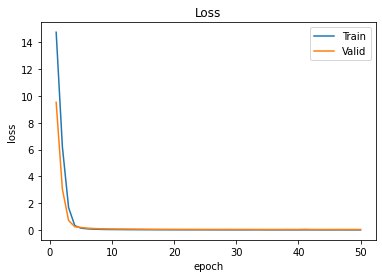

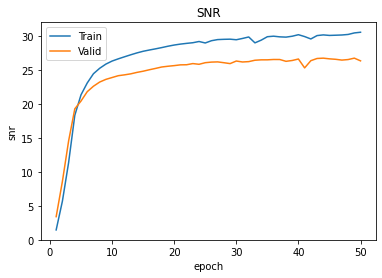


Sample 1:


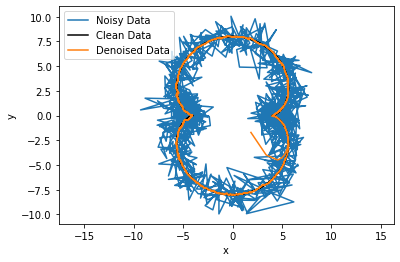


Sample 2:


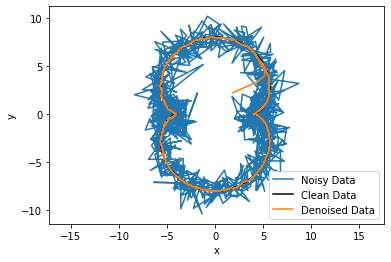


Sample 3:


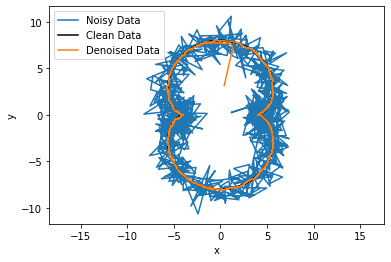


Sample 4:


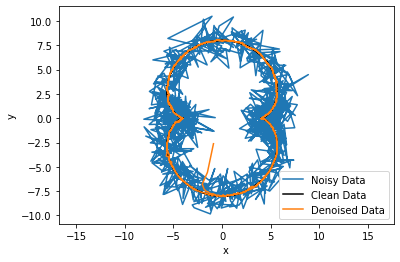


Sample 5:


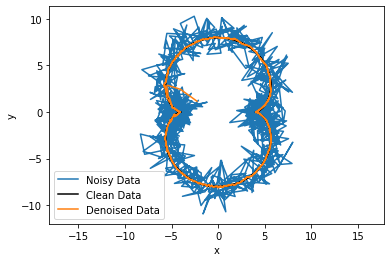

In [63]:
evaluationSignal(model, test_dataloader, criterion, accuracy, clean_train, dict_result, num_visual)

# **Media**

## **Dataset**

In [17]:
def vectorize(matrix, indices=None):
  return matrix[(indices[0], indices[1])]

class MediaDataset(Dataset):
  
  def __init__(self, path, isImage=True, RGB=True, vectorize=None, sample_rate=None, signal_time=None, data_size=32, 
               gaussian_noise=True, noise_variance=0.1, wss_noise=True, mean_variation=0.1, var_variation=0.1, visualization=False):
    self.isImage = isImage
    if isImage:
      img = Image.open(path)
      if sample_rate is not None:
        img = img.resize((img.width // sample_rate, img.height // sample_rate), Image.ANTIALIAS)
      self.clean_data = np.array(img) / 255.0 * 2 - 1.0
      if not RGB:
        self.clean_data = np.mean(self.clean_data, axis=-1, keepdims=True)

      if vectorize is None:
        self.vec_indices = np.where(np.ones_like(self.clean_data[:, :, 0], dtype=bool))
      else:
        self.vec_indices = vectorize(self.clean_data[:, :, 0].shape)

      self.clean_data = self.clean_data[self.vec_indices]
      signal_len = self.clean_data.shape[0]

    else:
      self.clean_data, self.sample_rate = librosa.load(path, sr=sample_rate, mono=True)
      self.clean_data = np.expand_dims(self.clean_data, axis=1)
      signal_len = self.clean_data.shape[0]
      if signal_time is not None:
        signal_len = min(signal_len, int(signal_time * self.sample_rate))
        self.clean_data = self.clean_data[:signal_len]

    self.data_size = data_size
    self.noisy_data = np.zeros((data_size, self.clean_data.shape[0], self.clean_data.shape[1]))
    
    if wss_noise:
      noise_mean = np.zeros((signal_len, 1))
      noise_std = np.full((signal_len, 1), np.sqrt(noise_variance))
    else:
      noise_mean = uniform(0 - mean_variation, 0 + mean_variation, (signal_len, 1))
      noise_std = uniform(np.sqrt(max(noise_variance - var_variation, 0)), 
                          np.sqrt(noise_variance + var_variation), (signal_len, 1))
      
    for i in range(data_size):
      self.noisy_data[i] = self.clean_data

      if gaussian_noise:
        self.noisy_data[i] += normal(noise_mean, noise_std, (signal_len, 1))

      else:
        if isImage:
          noise_variance = min(noise_variance, 1.0)
          rand_probs = uniform(size=self.noisy_data[i].shape)
          self.noisy_data[i][np.where(rand_probs < noise_variance / 2)] = -1.0
          self.noisy_data[i][np.where(rand_probs > 1 - noise_variance / 2)] = 1.0

        else:
          self.noisy_data[i] += uniform(noise_mean - np.sqrt(3) * noise_std, noise_mean + np.sqrt(3) * noise_std, (signal_len, 1))
    
    if visualization:
      index = randint(data_size)

      if isImage:
        data_arr = np.zeros((max(self.vec_indices[0]) + 1, max(self.vec_indices[1]) + 1, self.clean_data.shape[-1]))
        
        if RGB:
          data_arr[self.vec_indices] = self.clean_data
          plt.figure()
          plt.imshow(data_arr / 2.0 + 0.5)
          plt.title('Clean Image')
          plt.axis('off')
          plt.show()
          
          data_arr[self.vec_indices] = self.noisy_data[index]
          plt.figure()
          plt.imshow(data_arr / 2.0 + 0.5)
          plt.title('Noisy Image')
          plt.axis('off')
          plt.show()
        
        else:
          data_arr[self.vec_indices] = self.clean_data
          plt.figure()
          plt.imshow(data_arr[:,:,0] / 2.0 + 0.5, cmap='gray')
          plt.title('Clean Image')
          plt.axis('off')
          plt.show()
          
          data_arr[self.vec_indices] = self.noisy_data[index]
          plt.figure()
          plt.imshow(data_arr[:,:,0] / 2.0 + 0.5, cmap='gray')
          plt.title('Noisy Image')
          plt.axis('off')
          plt.show()
      
      else:
        print('Clean Voice:')
        display(Audio(data=self.clean_data.squeeze(), rate=self.sample_rate))
        print('Noisy Voice:')
        display(Audio(data=self.noisy_data[index].squeeze(), rate=self.sample_rate))
    
  def __len__(self):
    return self.data_size

  def __getitem__(self, index):
    return (np.array(self.vec_indices) if self.isImage else self.sample_rate), self.clean_data.astype(np.float32), self.noisy_data[index].astype(np.float32)


## **Model**

In [18]:
class Denoising(nn.Module):
  def __init__(self, dimension=1, hidden_size=30, lstm=False):
    super(Denoising, self).__init__()
    model = nn.LSTM if lstm else nn.RNN

    self.rnn = model(dimension, hidden_size, batch_first=True)
    self.linear = nn.Linear(hidden_size, dimension)

  def forward(self, x):
    rnn_out, _ = self.rnn(x.to(torch.float32))
    pred = self.linear(rnn_out)
    return pred
    

## **Functions**

In [19]:
def trainMedia(model, num_epochs, train_dataloader, valid_dataloader, optimizer, criterion, accuracy, dict_result=None):

  if dict_result:
    tr_loss = np.concatenate((dict_result['tr_loss'], np.zeros((num_epochs))))
    tr_snr = np.concatenate((dict_result['tr_snr'], np.zeros((num_epochs))))

    val_loss = np.concatenate((dict_result['val_loss'], np.zeros((num_epochs))))
    val_snr = np.concatenate((dict_result['val_snr'], np.zeros((num_epochs))))

    epoch = dict_result['epoch']
    time = dict_result['time']

    pbar = tqdm(range(epoch, epoch + num_epochs), total=num_epochs, position=0, leave=False)
    pbar.start_t -= time
    pbar.display(f'Training: loss={tr_loss[-num_epochs - 1]:.3f} snr={tr_snr[-num_epochs - 1]:+.3f}dB | '
                 f'Validation: loss={val_loss[-num_epochs - 1]:.3f} snr={val_snr[-num_epochs - 1]:+.3f}dB | '
                 f'epoch={epoch + 1}/{epoch + num_epochs}:' + pbar.format_meter(0, num_epochs, time, rate=epoch / time))
    num_epochs += epoch

  else:
    tr_loss = np.zeros((num_epochs))
    tr_snr = np.zeros((num_epochs))
    
    val_loss = np.zeros((num_epochs))
    val_snr = np.zeros((num_epochs))

    pbar = tqdm(range(num_epochs), total=num_epochs, position=0, leave=False)
    dict_result = {}

  for epoch in pbar:
    model.train()
    tr_epoch_loss = 0
    tr_epoch_snr = 0
    count = 0

    for _, clean_data, noisy_data in train_dataloader:
      if torch.cuda.is_available():
        clean_data = clean_data.cuda()
        noisy_data = noisy_data.cuda()

      optimizer.zero_grad()
      denoised_data = model(noisy_data)
      loss = criterion(denoised_data, clean_data)
      snr = accuracy(denoised_data, clean_data)

      loss.backward()
      optimizer.step()
      tr_epoch_loss += loss.item()
      tr_epoch_snr += snr.item()
      count += 1
    
    tr_epoch_loss /= count
    tr_epoch_snr /= count

    tr_loss[epoch] = tr_epoch_loss
    tr_snr[epoch] = tr_epoch_snr

    model.eval()
    val_epoch_loss = 0
    val_epoch_snr = 0
    count = 0

    for _, clean_data, noisy_data in valid_dataloader:
      if torch.cuda.is_available():
        clean_data = clean_data.cuda()
        noisy_data = noisy_data.cuda()
      
      with torch.no_grad():
        denoised_data = model(noisy_data)
        loss = criterion(denoised_data, clean_data)
        snr = accuracy(denoised_data, clean_data)

        val_epoch_loss += loss.item()
        val_epoch_snr += snr.item()
        count += 1
    
    val_epoch_loss /= count
    val_epoch_snr /= count

    val_loss[epoch] = val_epoch_loss
    val_snr[epoch] = val_epoch_snr

    pbar.set_description(f'Training: loss={tr_epoch_loss:.3f} snr={tr_epoch_snr:+.3f}dB | Validation: loss={val_epoch_loss:.3f} snr={val_epoch_snr:+.3f}dB | epoch={epoch + 1}/{num_epochs}')

  pbar.display()

  time = pbar.format_dict['elapsed']
  dict_result['time'] = time
  dict_result['epoch'] = num_epochs

  dict_result['tr_loss'] = tr_loss
  dict_result['tr_snr'] = tr_snr

  dict_result['val_loss'] = val_loss
  dict_result['val_snr'] = val_snr

  return dict_result


def evaluationAudio(model, test_dataloader, criterion, accuracy, dict_result, num_visual):

  model.eval()
  test_loss = 0
  test_snr_in = 0
  test_snr_out = 0
  count = 0

  for media_info, clean_data, noisy_data in test_dataloader:
    if torch.cuda.is_available():
      clean_data = clean_data.cuda()
      noisy_data = noisy_data.cuda()

    with torch.no_grad():
      denoised_data = model(noisy_data)
      loss = criterion(denoised_data, clean_data)
      snr_in = accuracy(noisy_data, clean_data)
      snr_out = accuracy(denoised_data, clean_data)

      test_loss += loss.item()
      test_snr_in += snr_in.item()
      test_snr_out += snr_out.item()
      count += 1
  
  test_loss /= count
  test_snr_in /= count
  test_snr_out /= count

  print(f'Testing: loss={test_loss:.3f} snr_in={test_snr_in:+.3f}dB snr_out={test_snr_out:+.3f}dB')
  
  epochs = range(1, dict_result['epoch'] + 1)

  plt.figure()
  plt.plot(epochs, dict_result['tr_loss'])
  plt.plot(epochs, dict_result['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss')
  plt.legend(['Train', 'Valid'])
  plt.show()
  
  plt.figure()
  plt.plot(epochs, dict_result['tr_snr'])
  plt.plot(epochs, dict_result['val_snr'])
  plt.xlabel('epoch')
  plt.ylabel('snr')
  plt.title('SNR')
  plt.legend(['Train', 'Valid'])
  plt.show()

  media_info = media_info.cpu().numpy()
  clean_data = clean_data.cpu().numpy()
  noisy_data = noisy_data.cpu().numpy()
  denoised_data = denoised_data.cpu().numpy()
  
  isImage = len(media_info.shape) == 3
  media_info = media_info[0]
  if isImage:
    media_info = (media_info[0], media_info[1])
    data_arr = np.zeros((max(media_info[0]) + 1, max(media_info[1]) + 1, clean_data.shape[-1]))

  if isImage:
    if clean_data.shape[2] == 3:
      data_arr[media_info] = clean_data[0]
      plt.figure()
      plt.imshow(data_arr / 2.0 + 0.5)
      plt.title('Clean Image')
      plt.axis('off')
      plt.show()

    else:
      data_arr[media_info] = clean_data[0]
      plt.figure()
      plt.imshow(data_arr[:,:,0] / 2.0 + 0.5, cmap='gray')
      plt.title('Clean Image')
      plt.axis('off')
      plt.show()

  else:
    print('Clean Voice:')
    display(Audio(data=clean_data[0].squeeze(), rate=media_info))

  for index in range(min(clean_data.shape[0], num_visual)):
    print()
    print(f'Sample {index + 1}:')
    if isImage:
      if clean_data.shape[2] == 3:
        data_arr[media_info] = noisy_data[index]
        plt.figure()
        plt.imshow(data_arr / 2.0 + 0.5)
        plt.title('Noisy Image')
        plt.axis('off')
        plt.show()

        data_arr[media_info] = denoised_data[index]
        plt.figure()
        plt.imshow(data_arr / 2.0 + 0.5)
        plt.title('Denoised Image')
        plt.axis('off')
        plt.show()

      else:
        data_arr[media_info] = noisy_data[index]
        plt.figure()
        plt.imshow(data_arr[:,:,0] / 2.0 + 0.5, cmap='gray')
        plt.title('Noisy Image')
        plt.axis('off')
        plt.show()
        
        data_arr[media_info] = denoised_data[index]
        plt.figure()
        plt.imshow(data_arr[:,:,0] / 2.0 + 0.5, cmap='gray')
        plt.title('Denoised Image')
        plt.axis('off')
        plt.show()

    else:
      print('Noisy Voice:')
      display(Audio(data=noisy_data[index].squeeze(), rate=media_info))
      print('Denoised Voice:')
      display(Audio(data=denoised_data[index].squeeze(), rate=media_info))


## **Parameters**

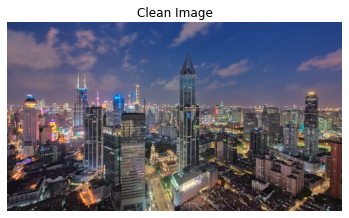

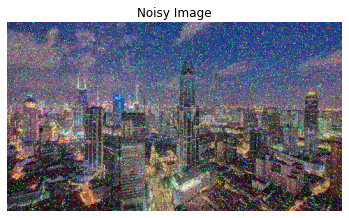

In [58]:
isImage = True
path = '/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Images/city-sample.jpg' if isImage else'/content/drive/MyDrive/Colab Notebooks/Deep/HW3/Voices/voice-sample.wav'
RGB = True
sample_rate = 4
signal_time = None
data_size = 50
gaussian_noise = False
noise_variance = 0.1
wss_noise = True
mean_variation = 0.5
var_variation = 0.5

def vectorize(image_shape):
  i_indices, j_indices = np.where(np.ones(image_shape, dtype=bool))

  # column reshape
  # i_indices = i_indices.reshape(image_shape).transpose().flatten()
  # j_indices = j_indices.reshape(image_shape).transpose().flatten()

  # gcd = np.gcd(image_shape[0], image_shape[1])
  # nrows, ncols = image_shape[0] // gcd, image_shape[1] // gcd

  # block row reshape
  # i_indices = i_indices.reshape(image_shape).reshape(image_shape[0] // nrows, nrows, image_shape[1] // ncols, ncols).swapaxes(1,2).flatten()
  # j_indices = j_indices.reshape(image_shape).reshape(image_shape[0] // nrows, nrows, image_shape[1] // ncols, ncols).swapaxes(1,2).flatten()

  # block column reshape
  # i_indices = i_indices.reshape(image_shape).transpose().reshape(image_shape[1] // ncols, ncols, image_shape[0] // nrows, nrows).swapaxes(1,2).flatten()
  # j_indices = j_indices.reshape(image_shape).transpose().reshape(image_shape[1] // ncols, ncols, image_shape[0] // nrows, nrows).swapaxes(1,2).flatten()

  return i_indices, j_indices

dimension = 1 if not isImage else (3 if RGB else 1)
batch_size = 100
hidden_size = 32
lstm = True
learning_rate = 0.01
num_epochs = 50
num_visual = 5

train_dataset = MediaDataset(path=path, isImage=isImage, RGB=RGB, vectorize=vectorize, sample_rate=sample_rate, signal_time=signal_time, data_size=20,
                             gaussian_noise=gaussian_noise, noise_variance=noise_variance,
                             wss_noise=wss_noise, mean_variation=mean_variation, var_variation=var_variation, visualization=True)
valid_dataset = MediaDataset(path=path, isImage=isImage, RGB=RGB, vectorize=vectorize, sample_rate=sample_rate, signal_time=signal_time, data_size=4, 
                             gaussian_noise=gaussian_noise, noise_variance=noise_variance, 
                             wss_noise=wss_noise, mean_variation=mean_variation, var_variation=var_variation, visualization=False)
test_dataset = MediaDataset(path=path, isImage=isImage, RGB=RGB, vectorize=vectorize, sample_rate=sample_rate, signal_time=signal_time, data_size=10, 
                            gaussian_noise=gaussian_noise, noise_variance=noise_variance, 
                            wss_noise=wss_noise, mean_variation=mean_variation, var_variation=var_variation, visualization=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=data_size)
test_dataloader = DataLoader(test_dataset, batch_size=data_size)

dict_result = None
model = Denoising(dimension=dimension, hidden_size=hidden_size, lstm=lstm)
if torch.cuda.is_available():
  model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
accuracy = lambda x, y: torch.mean(10 * torch.log10(torch.sum(torch.pow(y, 2), dim=1) / torch.sum(torch.pow(y - x, 2), dim=1)))


## **Training**

In [59]:
dict_result = trainMedia(model, num_epochs, train_dataloader, valid_dataloader, optimizer, criterion, accuracy, dict_result)

Training: loss=0.025 snr=+8.618dB | Validation: loss=0.025 snr=+8.611dB | epoch=50/50: 100%|██████████| 50/50 [04:04<00:00,  4.85s/it]

## **Evaluation**

In [60]:
evaluationAudio(model, test_dataloader, criterion, accuracy, dict_result, num_visual)

Output hidden; open in https://colab.research.google.com to view.